In [75]:
# yfinance to get data
import yfinance as yf

# pandas to manipulate dataframe
import pandas as pd

# plotly to plot
import plotly.graph_objects as go
import plotly.io as pio

import statsmodels.api as sm
import datetime as dt
import pandas_datareader.data as reader

### Simple Data Manipulation and plotting

In [81]:
# get data
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01')

[*********************100%%**********************]  1 of 1 completed


In [28]:
# plot ohlc graph
fig = go.Figure(data=go.Ohlc(x=df.index, 
                             open=df['Open'], 
                             high=df['High'], 
                             low=df['Low'], 
                             close=df['Close'])) 

#fig.show()


In [23]:
# this would be daily returns

df['Return'] = df.Close.pct_change()

In [24]:
# over time, your cumulative daily return
daily_cum_returns = (df['Return']+1).cumprod()
daily_cum_returns

Date
2020-01-02         NaN
2020-01-03    0.990278
2020-01-06    0.998169
2020-01-07    0.993474
2020-01-08    1.009456
                ...   
2024-06-28    2.804994
2024-07-01    2.886632
2024-07-02    2.933511
2024-07-03    2.950558
2024-07-05    3.014350
Name: Return, Length: 1134, dtype: float64

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=daily_cum_returns,
    mode='lines+markers',
    name='Daily Cumulative Returns'
))

### Stock Beta

In [33]:
end = dt.datetime.now()
start = dt.date(end.year - 5, end.month, end.day)
Input = ['MSFT', '^GSPC']

In [38]:
df = yf.download(Input, start, end)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [66]:
mtl_ret = df.resample('ME').ffill().pct_change()
mtl_ret = mtl_ret.dropna()

In [67]:
x = mtl_ret['^GSPC']
y = mtl_ret['MSFT']

x_sm = sm.add_constant(x)

In [68]:
model = sm.OLS(y, x_sm)

In [69]:
results = model.fit()

In [70]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     70.70
Date:                Sun, 07 Jul 2024   Prob (F-statistic):           1.27e-11
Time:                        19:44:05   Log-Likelihood:                 105.09
No. Observations:                  60   AIC:                            -206.2
Df Residuals:                      58   BIC:                            -202.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0129      0.006      2.280      0.026       0.002       0.024
^GSPC          0.8966      0.107      8.408      0.000       0.683       1.110
==============================================================================
Omnibus:                        3.838   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                3.485
Skew:                           0.589   Prob(JB):                        0.175
Kurtosis:                       2.936   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [71]:
import seaborn as sns

<Axes: xlabel='^GSPC', ylabel='MSFT'>

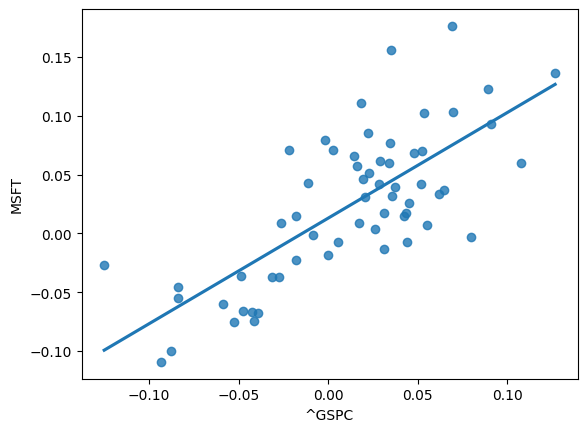

In [73]:
sns.regplot(x='^GSPC', y='MSFT', data=mtl_ret, ci=None)

In [77]:
rf = reader.DataReader('F-F_Research_Data_Factors', 'famafrench', start, end)[0].RF

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_10132\1284863811.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_10132\1284863811.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [78]:
rf = rf[1:]

In [80]:
#mtl_ret['MSFT-rf'], mtl_ret['^GSPC-rf'] = mtl_ret['MSFT'] - rf.values, mtl_ret['^GSPC'] - rf.values

### Fama French Regression in python

In [84]:
end = dt.date(2020, 6, 30)
start = dt.date(end.year - 5, end.month, end.day)
funds = ['FDGRX']

In [90]:
funds_ret = yf.download(funds, start, end)['Adj Close'].pct_change()

[*********************100%%**********************]  1 of 1 completed


In [93]:
funds_ret_mtl = funds_ret.resample('ME').agg(lambda x: (x+1).prod() - 1)
funds_ret_mtl = funds_ret_mtl[1:]

In [101]:
factors = reader.DataReader('F-F_Research_Data_Factors', 'famafrench', start, end)[0]

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_10132\3513935080.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.

C:\Users\Bogdan\AppData\Local\Temp\ipykernel_10132\3513935080.py:1: FutureWarning:

The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.



In [102]:
factors = factors[1:]

In [107]:
funds_ret_mtl.index = factors.index

In [109]:
merge = pd.merge(funds_ret_mtl, factors, on='Date')

In [111]:
merge[['Mkt-RF', 'SMB', 'HML', 'RF']] = merge[['Mkt-RF', 'SMB', 'HML', 'RF']]/100

In [113]:
merge['FDGRX-RF'] = merge['Adj Close'] - merge.RF

In [115]:
merge = merge.rename(columns={'Adj Close': 'FDGRX'})

In [116]:
merge

,FDGRX,Mkt-RF,SMB,HML,RF,FDGRX-RF
Date,,,,,,
2015-07,0.037106,0.0154,-0.0417,-0.0413,0.0000,0.037106
2015-08,-0.067351,-0.0604,0.0033,0.0277,0.0000,-0.067351
2015-09,-0.040284,-0.0307,-0.0262,0.0056,0.0000,-0.040284
2015-10,0.083025,0.0775,-0.0188,-0.0046,0.0000,0.083025
2015-11,0.020907,0.0056,0.0360,-0.0042,0.0000,0.020907
2015-12,-0.010148,-0.0217,-0.0284,-0.0261,0.0001,-0.010248
2016-01,-0.106114,-0.0577,-0.0342,0.0209,0.0001,-0.106214
2016-02,-0.012863,-0.0007,0.0073,-0.0057,0.0002,-0.013063
2016-03,0.068304,0.0696,0.0082,0.0119,0.0002,0.068104


In [117]:
y = merge['FDGRX-RF']
x = merge[['Mkt-RF', 'SMB', 'HML']]

x_sm = sm.add_constant(x)

In [118]:
model = sm.OLS(y, x_sm)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FDGRX-RF   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     297.8
Date:                Sun, 07 Jul 2024   Prob (F-statistic):           2.23e-34
Time:                        20:21:59   Log-Likelihood:                 174.97
No. Observations:                  60   AIC:                            -341.9
Df Residuals:                      56   BIC:                            -333.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.002      0.857      0.395      -0.002       0.005
Mkt-RF         1.1649      0.043     26.812      0.000       1.078       1.252
SMB            0.1867      0.078      2.379      0.021       0.029       0.344
HML           -0.4954      0.056     -8.814      0.000      -0.608      -0.383
==============================================================================
Omnibus:                        0.365   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.275
Skew:                          -0.160   Prob(JB):                        0.871
Kurtosis:                       2.916   Cond. No.                         46.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""